In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ARIMA, SARIMAX
from arch import arch_model
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')


In [22]:
df = pd.read_excel('./data/LME_westmetall_db.xlsx', index_col='date',parse_dates=['date']).drop('Unnamed: 0', axis=1)

---

### Copper

<AxesSubplot: xlabel='date'>

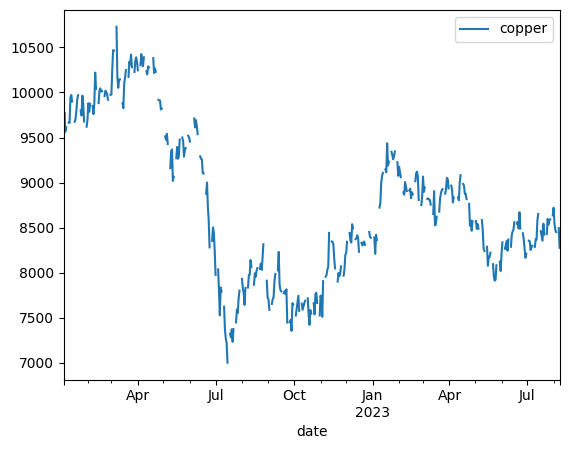

In [23]:
df_copper = pd.DataFrame(df['copper'], index= df.index)
df_copper = df_copper.asfreq('D') 
df_copper.plot()

Interpolation

In [24]:
df_copper['copper'] = df_copper['copper'].interpolate(method='linear')

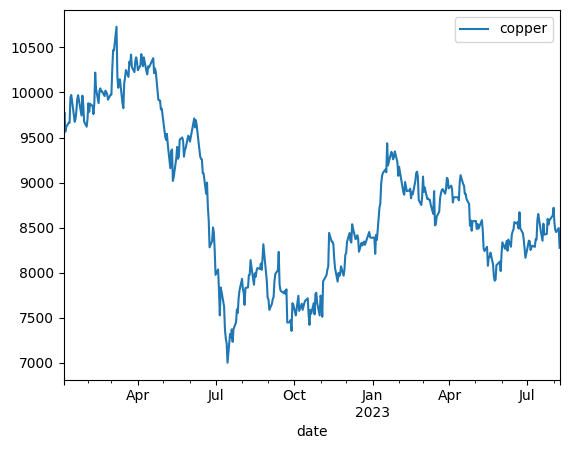

In [25]:
df_copper.plot()
plt.show()

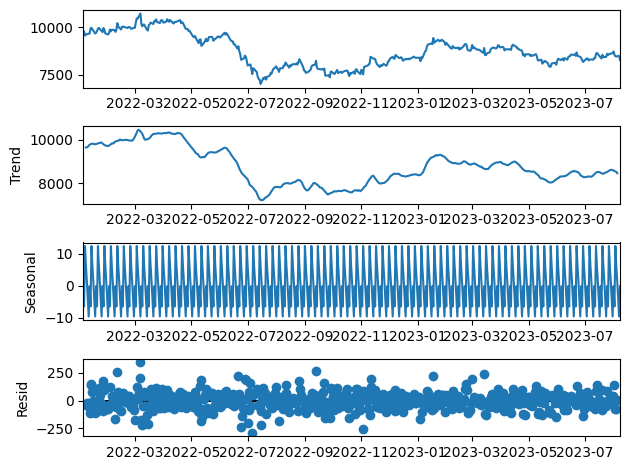

In [26]:
decompose = seasonal_decompose(df_copper)
decompose.plot()
plt.show()

<AxesSubplot: xlabel='date'>

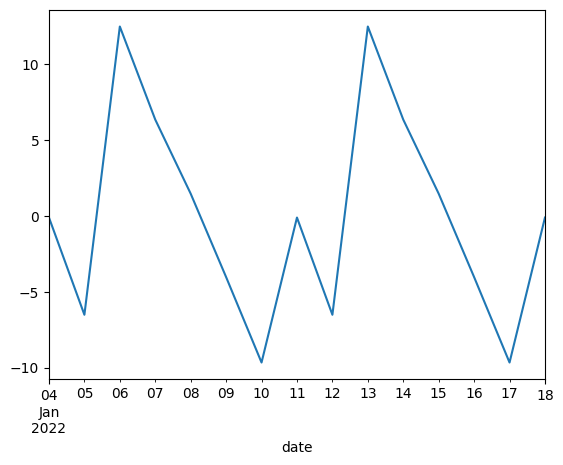

In [27]:
decompose.seasonal[:15].plot()

seasonal component = 7

---

Train/test split

In [36]:
train_df = df_copper[:-3]
test_df = df_copper[-3:]

MA prediction = baseline

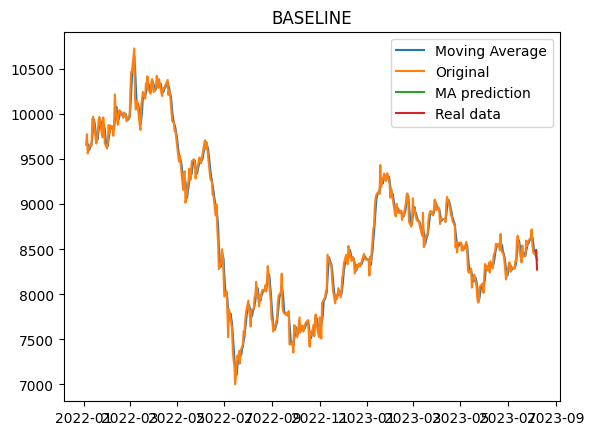

RMSE for MA: 83.05250211159156


In [37]:
# Moving average prediction
def ma_prediction(train_data, test_data=None, window_size=test_df.shape[0], pred_num=test_df.shape[0]):

    data_ma = train_data.rolling(window_size).mean()
    last_values = data_ma.tail(window_size).values
    prediction = np.array([last_values[-1] +
                           (last_values[-1] - last_values[-2]) * i for i in range(1, pred_num + 1)])
    prediction = pd.DataFrame(
        prediction, columns=test_data.columns, index=test_data.index)
    return data_ma, prediction


ma_model, ma_pred = ma_prediction(train_df, test_df, window_size=3)
plt.plot(ma_model, label='Moving Average')
plt.plot(train_df, label='Original')
plt.plot(ma_pred, label='MA prediction')
plt.plot(test_df, label='Real data')
plt.title('BASELINE')
plt.legend()
plt.show()
ma_rmse = np.sqrt(mean_squared_error(test_df, ma_pred))
print(f'RMSE for MA: {ma_rmse}')


In [38]:
ma_pred

,copper
date,
2023-08-06,8436.055556
2023-08-07,8409.500000
2023-08-08,8382.944444


In [39]:
test_df

,copper
date,
2023-08-06,8480.166667
2023-08-07,8495.000000
2023-08-08,8276.000000


Stationarity check

In [40]:
def stationary(data, p_value=0.05):
    stats = adfuller(data)
    if stats[1] > p_value:
        print('Not stationary')
    else:
        print('Stationary')


stationary(df_copper)


Not stationary


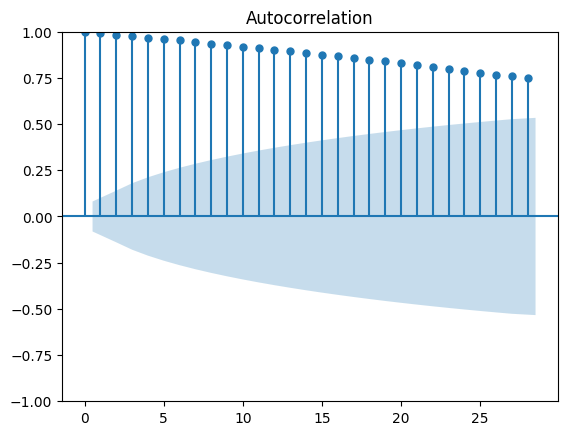

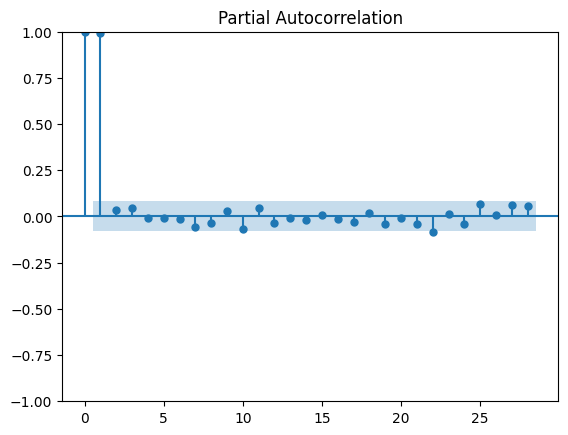

In [41]:
acf = plot_acf(df_copper)
plt.show()
pacf = plot_pacf(df_copper)
plt.show()

In [42]:
stationary(df_copper_diff_1 := df_copper.diff().dropna())

Stationary


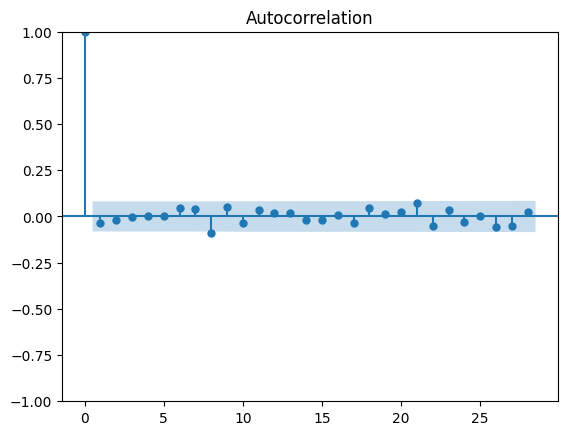

In [43]:
acf = plot_acf(df_copper_diff_1)
plt.show()

p = 1 (partial autocor), d = 1(number of differiantial), q = 8 (auto-correlation on diffseries)

In [44]:
p = 1
d = 1
q = 1

arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 copper   No. Observations:                  579
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3492.955
Date:                Wed, 09 Aug 2023   AIC                           6991.911
Time:                        12:32:44   BIC                           7004.989
Sample:                    01-04-2022   HQIC                          6997.010
                         - 08-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3123      1.044      0.299      0.765      -1.735       2.359
ma.L1         -0.3489      1.033     -0.338      0.736      -2.373       1.675
sigma2      1.036e+04    390.836     26.511      0.000    9595.307    1.11e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               266.35
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
pred_df = pd.DataFrame(index=test_df.index)

pred_df["copper"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

forecast = arima_model_fit.get_forecast(len(test_df))
forecast_df = forecast.conf_int(alpha=0.05)


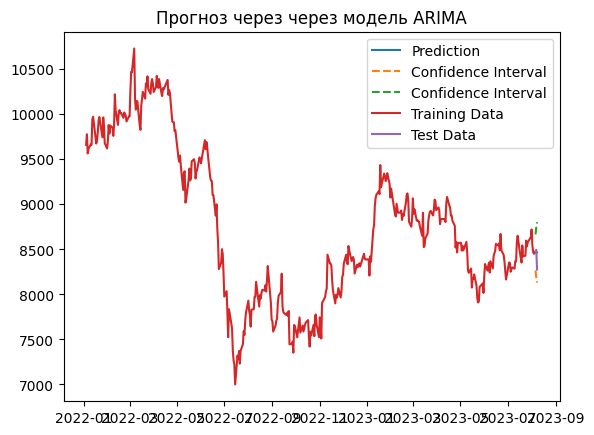

In [46]:
plt.plot(pred_df, label='Prediction')
plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
plt.plot(train_df, label='Training Data')
plt.plot(test_df, label='Test Data')
plt.title('Прогноз через через модель ARIMA')
plt.legend()
plt.show()


In [47]:
pred_df

,copper
date,
2023-08-06,8465.612318
2023-08-07,8465.699438
2023-08-08,8465.726644


In [48]:
test_df

,copper
date,
2023-08-06,8480.166667
2023-08-07,8495.000000
2023-08-08,8276.000000


autoarima

<bound method ARIMA.arparams of ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>


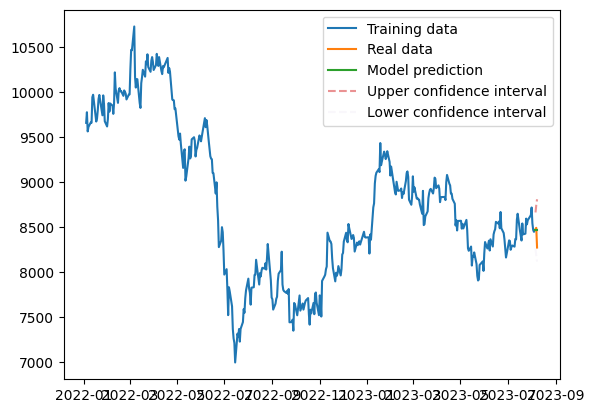

In [49]:
model_auto = pm.auto_arima(train_df)
forecast, conf_int = model_auto.predict(n_periods=test_df.shape[0], return_conf_int=True)

auto_rmse = np.sqrt(mean_squared_error(test_df, forecast))
print(model_auto.arparams)

conf_low = pd.DataFrame(conf_int.T[0], columns=[
                        'lower_bound'], index=test_df.index)
conf_high = pd.DataFrame(conf_int.T[1], columns=[
                         'upper_bound'], index=test_df.index)


plt.plot(train_df, label='Training data')
plt.plot(test_df, label='Real data')
plt.plot(forecast, label='Model prediction')
plt.plot(conf_high, linestyle="--",
         label='Upper confidence interval', alpha=0.5)
plt.plot(conf_low, linestyle="--", label='Lower confidence interval', alpha=0.05)
plt.legend()
plt.show()


In [50]:
test_df

,copper
date,
2023-08-06,8480.166667
2023-08-07,8495.000000
2023-08-08,8276.000000


In [51]:
forecast

2023-08-06    8465.333333
2023-08-07    8465.333333
2023-08-08    8465.333333
Freq: D, dtype: float64

---

In [52]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=7324.297, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=7177.421, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=7324.594, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=7112.446, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=7111.682, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=7177.916, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=7112.410, Time=0.28 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=inf, Time=1.83 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=7113.673, Time=0.43 sec

B

In [53]:
seas_model = SARIMAX(
    train_df["copper"].dropna(), order=(0, 1, 0), seasonal_order=(2, 1, 0, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13617D+00    |proj g|=  1.77401D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   1.773D-05   6.136D+00
  F =   6.1361674733320291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            copper   No. Observations:                  579
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -3552.841
Date:                           Wed, 09 Aug 2023   AIC                           7111.682
Time:                                   12:33:34   BIC                           7124.735
Sample:                               01-04-2022   HQIC                          7116.773
                                    - 08-05-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.6397      0.036    -17.844      0.000      -0.710      -0.569
ar.S.L10      -0.3362      0.033    -10.302      0.000      -0.400      -0.272
sigma2      1.411e+04    576.049     24.496      0.000     1.3e+04    1.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):               128.32
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
pred_df = pd.DataFrame(index=test_df.index)

pred_df["copper"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

In [55]:
pred_df

,copper
date,
2023-08-06,8510.357852
2023-08-07,8452.125563
2023-08-08,8431.123706


In [56]:
test_df

,copper
date,
2023-08-06,8480.166667
2023-08-07,8495.000000
2023-08-08,8276.000000


---

GARCH

In [16]:
df_copper['volatility'] = df['copper'].pct_change(1).mul(100).abs()
train_df = df_copper[:-7]
test_df = df_copper[-7:]

In [17]:
train_df

,copper,volatility
date,,
2022-01-04,9660.000000,NaN
2022-01-05,9778.000000,1.221532
2022-01-06,9565.000000,2.178360
2022-01-07,9615.000000,0.522739
2022-01-08,9631.666667,NaN
...,...,...
2023-07-28,8592.000000,0.157370
2023-07-29,8606.500000,NaN
2023-07-30,8621.000000,NaN


In [18]:
garch_df = pd.DataFrame(df_copper["volatility"].loc[df_copper.index])
garch_df.loc[train_df.index, "volatility"] = train_df["volatility"].dropna()

model = arch_model(garch_df["volatility"].dropna(), p=7, q=7, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0], update_freq=3)
model_results.summary()

Iteration:      3,   Func. Count:     56,   Neg. LLF: 10297.22995905717
Iteration:      6,   Func. Count:    111,   Neg. LLF: 778.9153288257012
Iteration:      9,   Func. Count:    164,   Neg. LLF: 550.5804177853454
Iteration:     12,   Func. Count:    216,   Neg. LLF: 550.2286112800049
Iteration:     15,   Func. Count:    267,   Neg. LLF: 550.2283240764227
Optimization terminated successfully    (Exit mode 0)
            Current function value: 550.2283240764227
            Iterations: 16
            Function evaluations: 283
            Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -550.228
Distribution:                  Normal   AIC:                           1132.46
Method:            Maximum Likelihood   BIC:                           1196.16
                                        No. Observations:                  396
Date:                Wed, Aug 09 2023   Df Residuals:                      395
Time:                        12:30:32   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.1228  5.974e-02     18.797  7.987e-79 [  1.006,  1.240]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5094      0.256      1.987  4.692e-02  [6.929e-03,  1.012]
alpha[1]       0.0604      0.118      0.512      0.609    [ -0.171,  0.292]
alpha[2]   2.9094e-11  9.688e-02  3.003e-10      1.000    [ -0.190,  0.190]
alpha[3]   2.3717e-11      0.186  1.278e-10      1.000    [ -0.364,  0.364]
alpha[4]       0.2078      0.145      1.434      0.152 [-7.623e-02,  0.492]
alpha[5]       0.1062      0.208      0.512      0.609    [ -0.301,  0.513]
alpha[6]   3.3345e-12  9.225e-02  3.615e-11      1.000    [ -0.181,  0.181]
alpha[7]       0.1523      0.180      0.845      0.398    [ -0.201,  0.505]
beta[1]    1.0019e-11      0.488  2.053e-11      1.000    [ -0.956,  0.956]
beta[2]    1.2813e-11      0.375  3.421e-11      1.000    [ -0.734,  0.734]
beta[3]    5.6430e-12      0.431  1.310e-11      1.000    [ -0.844,  0.844]
beta[4]    5.8075e-12      0.226  2.574e-11      1.000    [ -0.442,  0.442]
beta[5]    1.9368e-11      0.583  3.320e-11      1.000    [ -1.143,  1.143]
beta[6]        0.0000      0.570      0.000      1.000    [ -1.117,  1.117]
beta[7]    4.2796e-12      0.435  9.836e-12      1.000    [ -0.853,  0.853]
===========================================================================

Covariance estimator: robust
"""

In [19]:
model_results.forecast().residual_variance

,h.1
date,
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN
2022-01-10,NaN
2022-01-11,NaN
...,...
2023-08-02,0.901416
2023-08-03,0.714880
2023-08-04,0.654450


In [20]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

plt.plot(predictions_df['Predictions'], label = 'Predicted volatility')
plt.plot(predictions_df['volatility'].abs(), label = 'Actual volatility')
plt.legend()
plt.show()

KeyError: "[Timestamp('2023-08-05 00:00:00'), Timestamp('2023-08-06 00:00:00')] not in index"